In [ ]:
%pip install sklearn-hierarchical-classification
!pip install scikit-multilearn
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_multilabel_classification
from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT
import json
import os
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.metrics import accuracy_score
from skmultilearn.adapt import MLkNN
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT
from networkx import DiGraph
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

!pip install transformers

  Preparing metadata (setup.py) ... done
  Created wheel for sklearn-hierarchical-classification: filename=sklearn_hierarchical_classification-1.3.2-py3-none-any.whl size=16915 sha256=446c419931bed728919970216f94ae468ae612187c5c8ce0b3e54dcce6b80878
  Stored in directory: /root/.cache/pip/wheels/87/09/e3/1619c1a173b533be37bda720b5f5aaa719e116d66ff7c01a12
Successfully built sklearn-hierarchical-classification
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 798.8 kB/s eta 0:00:00


In [ ]:
"""
!pip install auto-sklearn
from pprint import pprint

import pandas as pd
import sklearn.metrics
from sklearn.datasets import fetch_20newsgroups

import autosklearn.classification
"""

# serie di 4 funzioni per la suddivisione del dataset secondo etichette
def find_descendants(graph, labels):
    descendants = set()

    def dfs(node):
        descendants.add(node)
        [dfs(child) for child in graph.successors(node)]

    [dfs(label) for label in labels]
    return descendants

def filter_matrix_by_labels(X, y, labels, graph):
    descendants_set = find_descendants(graph, labels)

    filtered_X, filtered_labels = zip(*[(X[i], list(set(labels_list) & descendants_set)) for i, labels_list in enumerate(y) if set(labels_list) & descendants_set])

    return np.vstack(filtered_X), list(filtered_labels)

def find_ancestor_in_labels(graph, node, target_labels):
    ancestors = set()

    def dfs(current):
        ancestors.add(current)
        [dfs(pred) for pred in graph.predecessors(current)]

    [dfs(predecessor) for predecessor in graph.predecessors(node)]

    common_ancestors = ancestors & set(target_labels)
    return list(common_ancestors)[0] if common_ancestors else None

def transform_Y_with_ancestors(graph, Y, target_labels):
    return [list(set([find_ancestor_in_labels(graph, label, target_labels) or label for label in labels_list])) for labels_list in Y]
###############################


def fit_classifier(X_Train, y_Train, G, labels_to_check, classifier, vectorizer):
    X, Y = filter_matrix_by_labels(X_train, y_train, labels_to_check, G)
    new_Y = transform_Y_with_ancestors(G, Y, labels_to_check)
    Y = Binarizzatore_etichette(labels_to_check, new_Y)
    X_tfidf = vectorizer.transform(X.flatten().tolist())

    return classifier.fit(X_tfidf, Y)


def Binarizzatore_etichette(lista_stringhe, lista_liste):
    # Inizializza la matrice con zeri
    matrice = [[0] * len(lista_stringhe) for _ in range(len(lista_liste))]

    # Riempie la matrice con 1 dove una stringa è presente nella lista di liste
    for i, lista in enumerate(lista_liste):
        for j, stringa in enumerate(lista_stringhe):
            if stringa in lista:
                matrice[i][j] = 1

    return matrice

def Etichette_da_Binarizzatore(lista_stringhe, matrice_binarizzatore):
    # Inizializza la lista di liste per le etichette
    lista_liste = [[] for _ in range(len(matrice_binarizzatore))]

    # Riempie la lista di liste con le etichette corrette
    for i, riga in enumerate(matrice_binarizzatore):
        for j, valore in enumerate(riga):
            if valore == 1:
                lista_liste[i].append(lista_stringhe[j])

    return lista_liste


def read_json_file(file_path):
    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        return data
    else:
        return None


def check_errors(graph, binary_vector, predicted_labels, true_labels):
    for pred_label, pred_value in zip(predicted_labels, binary_vector):
        if pred_value == 1 and not any(nx.has_path(graph.reverse(), label, pred_label) for label in true_labels):
            return False
        elif pred_value == 0 and pred_label in true_labels:
            return False

    return True  # Se non ci sono errori, restituisce True

In [ ]:
G = DiGraph()
G.add_edge(ROOT, "non_propagandistic")
G.add_edge(ROOT, "propagandistic")

np.set_printoptions(threshold=np.inf)
# Leggi train.json
train_data = read_json_file("train.json")

# Leggi validation.json
validation_data = read_json_file("val.json")

test_data = read_json_file("dev_subtask2b_en.json")


# Inizializza le liste per i dati di addestramento
texts_train, labels_train = [], []
texts_validation, labels_validation = [], []
texts_test, labels_test = [], []
texts_test_vero, labels_test_vero = [], []
if train_data:
    texts_train = [element['text'] for element in train_data]
    labels_train = [element['label'] if element['label'] else ['Free'] for element in train_data]

# Estre x e y dai dataset se esistono
if validation_data:
    texts_validation = [element['text'] for element in validation_data]
    labels_validation = [element['label'] if element['label'] else ['Free'] for element in validation_data]

if test_data:
    texts_test = [element['text'] for element in test_data]
    labels_test = [element['label'] if element['label'] else ['Free'] for element in test_data]

# Unisce i dati di addestramento e validation
texts = texts_train + texts_validation
labels = labels_train + labels_validation


"""
# Divide dataset in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)  # , stratify=results
"""
####### nuova sezione per avere validation.json come gold
X_test = texts_test
y_test = labels_test
X_train = texts
y_train = labels

In [ ]:
from transformers import pipeline

# Carica la pipeline di text classification
classifier = pipeline("text-classification", model="cstnz/PropagandaDetection")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/412 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
#print(X_test[40])
#classifier(X_test[0])
c = X_test[0]
c

'PUTIN SCROLLING HIS INSTA FOR G20 NEWS BE LIKE:\\nG20\\nINDONESIA\\n1011'

In [ ]:
max_token_limit = 800

# Lista per immagazzinare i risultati della pipeline
all_results = []

# Itera attraverso i testi
for text in X_test:
    # Limita la lunghezza del testo se necessario
    truncated_text = text[:max_token_limit]

    # Utilizza la pipeline per ottenere i risultati
    result = classifier(truncated_text)
    all_results.append(result)

In [ ]:
print(all_results)

[[{'label': 'NO_PROPAGANDA', 'score': 0.9995666146278381}], [{'label': 'PROPAGANDA', 'score': 0.9977942705154419}], [{'label': 'PROPAGANDA', 'score': 0.9945152401924133}], [{'label': 'NO_PROPAGANDA', 'score': 0.9980436563491821}], [{'label': 'NO_PROPAGANDA', 'score': 0.9982244372367859}], [{'label': 'NO_PROPAGANDA', 'score': 0.9996383190155029}], [{'label': 'NO_PROPAGANDA', 'score': 0.9983200430870056}], [{'label': 'PROPAGANDA', 'score': 0.9333972334861755}], [{'label': 'NO_PROPAGANDA', 'score': 0.9865114688873291}], [{'label': 'NO_PROPAGANDA', 'score': 0.9967135190963745}], [{'label': 'NO_PROPAGANDA', 'score': 0.992226243019104}], [{'label': 'NO_PROPAGANDA', 'score': 0.9993380904197693}], [{'label': 'PROPAGANDA', 'score': 0.9952849745750427}], [{'label': 'NO_PROPAGANDA', 'score': 0.9994814991950989}], [{'label': 'NO_PROPAGANDA', 'score': 0.9914532899856567}], [{'label': 'NO_PROPAGANDA', 'score': 0.9988127946853638}], [{'label': 'NO_PROPAGANDA', 'score': 0.9994865655899048}], [{'label'

In [ ]:
import re
# Utilizzare regex per estrarre il contenuto dopo 'label':
label_lists = [[re.search(r"'label':\s*'([^']+)'", str(result)).group(1)] for result in all_results]





In [ ]:
label_mapping = {
    'NO_PROPAGANDA': 'non_propagandistic',
    'PROPAGANDA': 'propagandistic'
}

# Applica la trasformazione alle etichette
transformed_labels = [label_mapping.get(re.search(r"'label':\s*'([^']+)'", str(result)).group(1), 'UNKNOWN')
                     for result in all_results]

In [ ]:
# NON SERVE PER USANDO CZAZAZZ

problematic_indices = [i for i, text in enumerate(X_train) if text is None]
print("Problematic Indices:", problematic_indices)

# Rimuovi gli elementi problematici sia da X_train che da y_train
X_train = [X_train[i] for i in range(len(X_train)) if i not in problematic_indices]
y_train = [y_train[i] for i in range(len(y_train)) if i not in problematic_indices]


vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
X_test = vectorizer.transform(X_test)
X_train = vectorizer.transform(X_train)
# Definizione dei classificatori
Free_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
Y = Binarizzatore_etichette(["non_propagandistic","propagandistic"], y_train)

Free_classifier.fit(X_train, Y)

y_prediction = Free_classifier.predict(X_test)
y_gold = Binarizzatore_etichette(["non_propagandistic","propagandistic"], y_test)
y_pred = Etichette_da_Binarizzatore(["non_propagandistic","propagandistic"], y_prediction)

In [ ]:
#############
y_gold = Binarizzatore_etichette(["non_propagandistic","propagandistic"], y_test)
y_pred = Binarizzatore_etichette(["non_propagandistic","propagandistic"], transformed_labels)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score
# Supponiamo di avere una lista di etichette 'propagandistic' e 'non_propagandistic'
labels = ['propagandistic', 'non_propagandistic', 'propagandistic', 'non_propagandistic']

# Inizializziamo il LabelBinarizer
binarizer = LabelBinarizer()

# Addestramento del binarizer sulle etichette
binarizer.fit(labels)

# Trasformazione delle etichette in formato binario
binary_labels_g = binarizer.transform(transformed_labels)
binary_labels_p= binarizer.transform(y_test)
f1 = f1_score(binary_labels_g, binary_labels_p, average='weighted')

# Stampa i risultati
print("f1={:.5f}".format(f1))

f1=0.47316


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcola le metriche
precision = precision_score(y_gold, y_pred, average='weighted')
recall = recall_score(y_gold, y_pred, average='weighted')
f1 = f1_score(y_gold, y_pred, average='weighted')

# Stampa i risultati
print("f1={:.5f}\tprecision={:.5f}\trecall={:.5f}".format(f1, precision, recall))


f1=0.87574	precision=0.83929	recall=0.96250


In [ ]:
import copy

# Creazione di copie profonde per evitare riferimenti condivisi
validation_data_aux = copy.deepcopy(test_data)

# Sostituisci i valori del campo 'labels' di validation_data_aux con quelli di aux
for i, element in enumerate(validation_data_aux):
    element["label"] = y_pred[i]


# Salva il nuovo validation_data modificato in un file pred.json
output_file_path = "pred4.json"
with open(output_file_path, "w", encoding='utf-8') as output_file:
    json.dump(validation_data_aux, output_file, indent=2)

In [ ]:
from sklearn.metrics import f1_score

macro_f1 = f1_score(y_gold, y_pred, average="macro", zero_division=1)
micro_f1 = f1_score(y_gold, y_pred, average="micro", zero_division=1)

print("macro-F1={:.5f}\tmicro-F1={:.5f}".format(macro_f1, micro_f1))

NameError: name 'y_gold' is not defined

 ############################################## INIZIO SEZIONE TEST #################################

In [ ]:
import json
def Binarizzatore_etichette(lista_stringhe, lista_liste):
    # Inizializza la matrice con zeri
    matrice = [[0] * len(lista_stringhe) for _ in range(len(lista_liste))]

    # Riempie la matrice con 1 dove una stringa è presente nella lista di liste
    for i, lista in enumerate(lista_liste):
        for j, stringa in enumerate(lista_stringhe):
            if stringa in lista:
                matrice[i][j] = 1

    return matrice
def process_json_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)

    binary_labels = []
    for element in data:
        labels_test = [element['label'] for element in data]
        binary_labels = Binarizzatore_etichette(["non_propagandistic","propagandistic"], labels_test)


    return binary_labels, labels_test

# Sostituisci 'file1.json' e 'file2.json' con i percorsi effettivi dei tuoi file JSON.
file1_path = 'dev_subtask2b_en.json'
#file2_path = 'predictions_TinyLlama_TinyLlama-1.1B-Chat-v1.0_openai_clip-vit-large-patch14_2_None_8_8_0.2_True.json'
file2_path = 'pred4.json'
y_gold, aaa = process_json_file(file1_path)
y_prediction, bbb = process_json_file(file2_path)

from sklearn.metrics import f1_score

macro_f1 = f1_score(y_gold, y_prediction, average="macro", zero_division=1)
micro_f1 = f1_score(y_gold, y_prediction, average="micro", zero_division=1)

print("macro-F1={:.5f}\tmicro-F1={:.5f}".format(macro_f1, micro_f1))

macro-F1=0.00000	micro-F1=0.00000


In [ ]:
from sklearn.metrics import f1_score

macro_f1 = f1_score(binary_labels_g, binary_labels_p, average="macro", zero_division=1)
micro_f1 = f1_score(binary_labels_g, binary_labels_p, average="micro", zero_division=1)

print("macro-F1={:.5f}\tmicro-F1={:.5f}".format(macro_f1, micro_f1))

macro-F1=0.43087	micro-F1=0.44000


In [ ]:
!pip install seaborn matplotlib scikit-learn

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


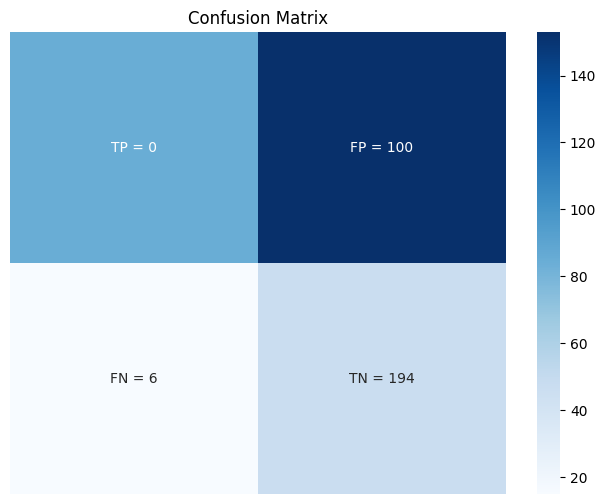

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Esempio di etichette originali

# Trasforma le etichette in vettori binari
label_encoder = LabelEncoder()
etichette_binarie = label_encoder.fit_transform(binary_labels_g)

# Sostituisci questi due vettori con i tuoi risultati effettivi e previsti
y_true = etichette_binarie
etichette_binarie = label_encoder.transform(binary_labels_p)
y_pred = etichette_binarie  # Esempio di vettore predetto

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(y_true, y_pred)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix_labels = [["TP = 0", "FP = 100"], ["FN = 6", "TN = 194"]]

# Plot della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=conf_matrix_labels, fmt="", cmap="Blues", xticklabels=[], yticklabels=[])

#plt.xlabel("Predicted Labels")
#plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

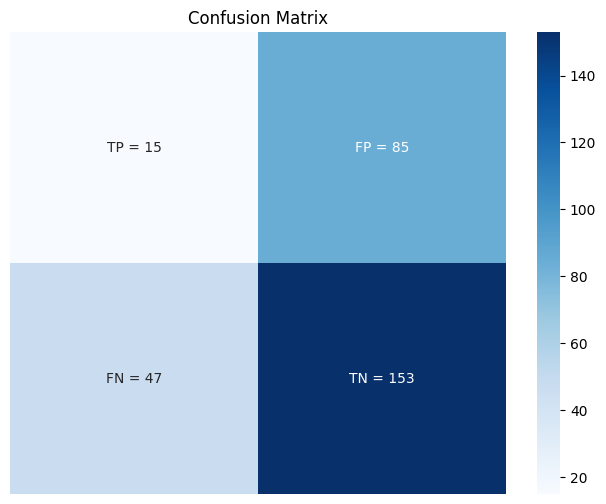

In [ ]:
conf_matrix =[[ 15, 85], [ 47, 153]]
conf_matrix_labels = [["TP = 15", "FP = 85"], ["FN = 47", "TN = 153"]]

# Plot della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=conf_matrix_labels, fmt="", cmap="Blues", xticklabels=[], yticklabels=[])

#plt.xlabel("Predicted Labels")
#plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()